In [2]:
import requests
from bs4 import BeautifulSoup
import re 
import pandas as pd 
import json
import time

In [2]:
def get_data_frames():
    '''
    This scrapes the site www.the-numbers.com for the years of 2009 until 2019
    '''
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    years = range(2009,2020)
    dfs = []
    for year in years:
        url = f'https://www.the-numbers.com/box-office-records/worldwide/all-movies/cumulative/released-in-{year}'
        time.sleep(2)
        html = requests.get(url, headers=headers) # avoid the 403
        yearly_df = pd.read_html(html.text)[1]
        yearly_df.dropna(inplace=True)
        yearly_df['year'] = year
        dfs.append(yearly_df)
    return dfs

frames = get_data_frames()
overall_df = pd.concat(frames, axis=0)

In [4]:
def clean_movie_names(dataframe):
    '''
    The movie names were coming back with some no ascii characters so this function cleans up 
    those characters and adds an apostrophe where those characters were located
    '''
    overall_df['clean_movie'] = overall_df.Movie.map(lambda x: x.replace("â", "'"))
    return overall_df

In [5]:
overall_df = clean_movie_names(overall_df)

In [257]:
overall_df.to_csv('Overall_DataFrame')

In [10]:
def get_ratings(dataframe):
    '''
    This calls an api from omdbapi.com and returns a dictionary of values for the specified movies
    that were in the yearly gross profits from get_data_frames
    '''
    movie_rating_list = []
    for api_req,year in zip(dataframe.clean_movie, dataframe.year): 
        movie_name = f"http://www.omdbapi.com/?t={api_req}&y={year}&apikey=b213361e"
        try:
            movie_ratings = requests.get(movie_name).json()
            movie_rating_list.append(movie_ratings)
        except ValueError:
            print('Name did not work')
    return pd.DataFrame(movie_rating_list)


In [11]:
ratings_df = get_ratings(overall_df)

Name did not work


In [258]:
ratings_df.to_csv('Ratings_DataFrame')

In [20]:
def get_tomato_score(row):
    try:
        tomato_val = [x.get('Value') for x in row if x.get('Source') == 'Rotten Tomatoes'][0]
        tomato_val = tomato_val.replace('%','')
        return int(tomato_val)
    except:
        return (None)

In [15]:
def imdb_clean(row):
    try:
        return float(row) * 10
    except:
        return(None)

In [16]:
def get_meta_score(row):
    try:
        return int(row)
    except:
        return(None)

In [21]:
ratings_df['Rotten_Score'] = ratings_df.Ratings.map(get_tomato_score)
ratings_df['Metacritic_Score'] = ratings_df.Metascore.map(get_meta_score)
ratings_df['Imdb_Score'] = ratings_df.imdbRating.map(imdb_clean)

In [78]:
joining_df = ratings_df[['Title','Rotten_Score','Metacritic_Score','Imdb_Score']].set_index('Title')

In [80]:
joined_df = overall_df[['Worldwide Box Office','Domestic Box Office','International Box Office',
                               'DomesticShare','year','clean_movie']].set_index('clean_movie')

In [81]:
final_df = joined_df.join(joining_df,on='clean_movie',how='inner')

In [82]:
final_df = final_df.dropna()

In [85]:
def clean_money(value):
    return (int(value.replace('$','').replace(',','')))


In [87]:
final_df['Worldwide Box Office'] = final_df['Worldwide Box Office'].map(clean_money)

In [89]:
final_df['Domestic Box Office'] = final_df['Domestic Box Office'].map(clean_money)

In [90]:
final_df['International Box Office'] = final_df['International Box Office'].map(clean_money)

In [95]:
final_df['DomesticShare'] = final_df['DomesticShare'].map(lambda x : float(x.replace('%','')))

In [108]:
final_df.corr()

,Worldwide Box Office,Domestic Box Office,International Box Office,DomesticShare,year,Rotten_Score,Metacritic_Score,Imdb_Score
Worldwide Box Office,1.000000,0.928512,0.982514,-0.295672,0.097691,0.265658,0.259872,0.317032
Domestic Box Office,0.928512,1.000000,0.843144,-0.040738,0.063359,0.333786,0.323734,0.353084
International Box Office,0.982514,0.843144,1.000000,-0.407738,0.109697,0.217327,0.213989,0.282046
DomesticShare,-0.295672,-0.040738,-0.407738,1.000000,-0.078203,0.079517,0.056938,-0.015189
year,0.097691,0.063359,0.109697,-0.078203,1.000000,0.110874,0.068772,0.061171
Rotten_Score,0.265658,0.333786,0.217327,0.079517,0.110874,1.000000,0.937325,0.772234
Metacritic_Score,0.259872,0.323734,0.213989,0.056938,0.068772,0.937325,1.000000,0.761331
Imdb_Score,0.317032,0.353084,0.282046,-0.015189,0.061171,0.772234,0.761331,1.000000


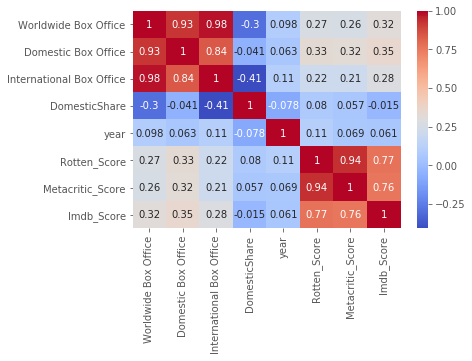

In [158]:
sns.heatmap(final_df.corr(),cmap='coolwarm',annot=True)

In [24]:
years = {x : final_df[final_df['year']==x] for x in range(2009, 2020)}

In [57]:
from collections import OrderedDict
def correlation_per_years(dataframe):
    corr_year_dict = OrderedDict()
    for year in range(2009,2020):
        key = 'corr' + str(year)
        corr_year_dict[key] = dataframe.query('year=='+str(year)).corr()
    return corr_year_dict

In [58]:
corr_dict = correlation_per_years(final_df)

In [59]:
def get_correlations_per_year(critic_source):
    corr_list=[]
    for year in range(2009,2020):
        corr_list.append(corr_dict['corr'+str(year)][critic_source][0])
    return corr_list

In [60]:
Imdb_corr_scores = get_correlations_per_year('Imdb_Score')

In [62]:
Rotten_corr_scores = get_correlations_per_year('Rotten_Score')

In [64]:
Meta_corr_scores = get_correlations_per_year('Metacritic_Score')

Text(0, 0.5, 'Correlation Value')

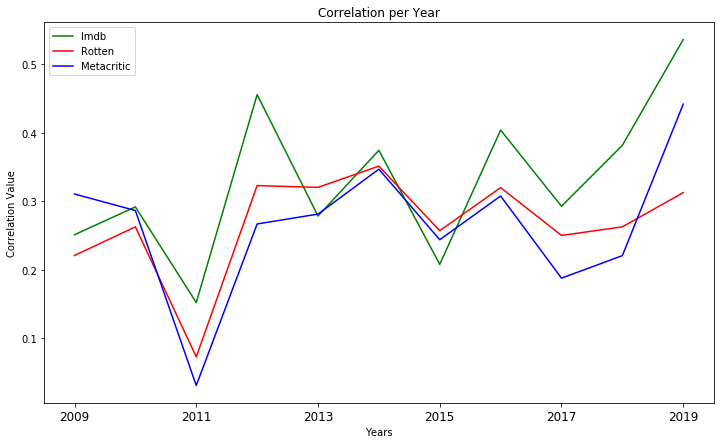

In [200]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize = (12,7))
ax.plot(Imdb_corr_scores,c='green',label='Imdb')
ax.plot(Rotten_corr_scores,c='red',label='Rotten')
ax.plot(Meta_corr_scores,c='blue',label='Metacritic')
ax.set_xticklabels(range(2007,2020,2), fontsize=12)
ax.legend(loc='best')
ax.set_title('Correlation per Year')
ax.set_xlabel('Years')
ax.set_ylabel("Correlation Value")

In [ ]:
fig.savefig("year_over_year_corr.png")

In [3]:
final_df = pd.read_csv('final_csv')

In [214]:
final_df.sort_values('Worldwide Box Office',ascending=False).head(14)

,clean_movie,Worldwide Box Office,Domestic Box Office,International Box Office,DomesticShare,year,Rotten_Score,Metacritic_Score,Imdb_Score
750,Avengers: Endgame,2795409509,858367305,1937042204,30.71,2019,94.0,78.0,86.0
0,Avatar,2789705275,760507625,2029197650,27.26,2009,82.0,83.0,78.0
689,Avengers: Infinity War,2048134200,678815482,1369318718,33.14,2018,85.0,68.0,85.0
475,Jurassic World,1648854864,652270625,996584239,39.56,2015,72.0,59.0,70.0
751,The Lion King,1599378019,529478019,1069900000,33.11,2019,53.0,55.0,71.0
476,Furious 7,1518722794,353007020,1165715774,23.24,2015,81.0,67.0,72.0
248,The Avengers,1517935897,623279547,894656350,41.06,2012,92.0,69.0,80.0
477,Avengers: Age of Ultron,1403013963,459005868,944008095,32.72,2015,75.0,66.0,73.0
690,Black Panther,1348258224,700059566,648198658,51.92,2018,96.0,88.0,73.0
691,Jurassic World: Fallen Kingdom,1305772799,417719760,888053039,31.99,2018,48.0,51.0,62.0


In [16]:
final_df.sort_values('Imdb_Score',ascending=False).head(10)

,clean_movie,Worldwide Box Office,Domestic Box Office,International Box Office,DomesticShare,year,Rotten_Score,Metacritic_Score,Imdb_Score
77,Inception,835524642,292576195,542948447,35.02,2010,87.0,74.0,88.0
406,Interstellar,665299250,188017894,477281356,28.26,2014,72.0,74.0,86.0
750,Avengers: Endgame,2795409509,858367305,1937042204,30.71,2019,94.0,78.0,86.0
689,Avengers: Infinity War,2048134200,678815482,1369318718,33.14,2018,85.0,68.0,85.0
626,Coco,798001982,209726015,588275967,26.28,2017,97.0,81.0,84.0
66,3 Idiots,69533849,6533849,63000000,9.40,2009,100.0,67.0,84.0
250,The Dark Knight Rises,1084439099,448139099,636300000,41.32,2012,87.0,78.0,84.0
261,Django Unchained,449948323,162805434,287142889,36.18,2012,86.0,81.0,84.0
75,Toy Story 3,1068879522,415004880,653874642,38.83,2010,98.0,92.0,83.0
15,Inglourious Basterds,316915264,120774594,196140670,38.11,2009,89.0,69.0,83.0


In [17]:
final_df.sort_values('Rotten_Score',ascending=False).head(10)

,clean_movie,Worldwide Box Office,Domestic Box Office,International Box Office,DomesticShare,year,Rotten_Score,Metacritic_Score,Imdb_Score
66,3 Idiots,69533849,6533849,63000000,9.40,2009,100.0,67.0,84.0
681,Lady Bird,78610769,48958273,29652496,62.28,2017,99.0,94.0,74.0
83,How to Train Your Dragon,494870992,217581232,277289760,43.97,2010,99.0,74.0,81.0
5,Up,731463377,293004164,438459213,40.06,2009,98.0,88.0,82.0
480,Inside Out,854235992,356461711,497774281,41.73,2015,98.0,94.0,82.0
75,Toy Story 3,1068879522,415004880,653874642,38.83,2010,98.0,92.0,83.0
648,Get Out,255367951,176040665,79327286,68.94,2017,98.0,84.0,77.0
528,Spotlight,92088460,45055776,47032684,48.93,2015,97.0,93.0,81.0
490,Mad Max: Fury Road,370098020,153636354,216461666,41.51,2015,97.0,90.0,81.0
617,Kubo and the Two Strings,77548122,48023088,29525034,61.93,2016,97.0,84.0,78.0


In [18]:
final_df.sort_values('Metacritic_Score',ascending=False).head(10)

,clean_movie,Worldwide Box Office,Domestic Box Office,International Box Office,DomesticShare,year,Rotten_Score,Metacritic_Score,Imdb_Score
327,Gravity,693698673,274092705,419605968,39.51,2013,96.0,96.0,77.0
616,Manchester by the Sea,77733867,47695371,30038496,61.36,2016,96.0,96.0,78.0
360,12 Years a Slave,181025343,56671993,124353350,31.31,2013,95.0,96.0,81.0
105,The Social Network,224922135,96962694,127959441,43.11,2010,96.0,95.0,77.0
295,Zero Dark Thirty,134612435,95720716,38891719,71.11,2012,92.0,95.0,74.0
480,Inside Out,854235992,356461711,497774281,41.73,2015,98.0,94.0,82.0
681,Lady Bird,78610769,48958273,29652496,62.28,2017,99.0,94.0,74.0
634,Dunkirk,499837368,190068280,309769088,38.03,2017,92.0,94.0,79.0
555,La La Land,426351163,151101803,275249360,35.44,2016,91.0,93.0,80.0
528,Spotlight,92088460,45055776,47032684,48.93,2015,97.0,93.0,81.0


In [48]:
final_df['Worldwide Box Office'].mean()

281204627.28230864

In [49]:
final_df['Domestic Box Office'].mean()

108718815.21455458

In [50]:
final_df['International Box Office'].mean()

172485812.0677541

In [55]:
final_df['Rotten_Score'].mean()

55.59723964868256

In [56]:
final_df['Imdb_Score'].mean()

65.27603513174404

In [57]:
final_df['Metacritic_Score'].mean()

54.429109159347554

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5cf067b550>,
      dtype=object)

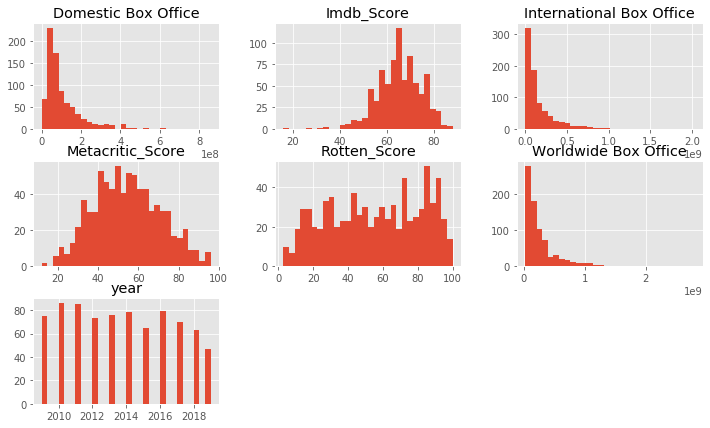

In [54]:
final_df.hist(figsize=(12,7),bins=30)

In [217]:
from collections import OrderedDict
def break_into_years(dataframe):
    '''
    This will break the data frame into a dicitionary of years
    Parameters
    ----------
    Data frame that is orderd by year 
    
    Returns
    -------
    years_dict:
    A dictionary of data frames split into the unique years. 
    '''
    years_dict = OrderedDict()
    for year in range(2009,2020):
        key = 'year' + str(year)
        years_dict[key] = final_df[final_df['year']==year]
    return years_dict

In [218]:
final_df.query('year==2009')
year2009 = final_df[final_df['year']==2009]
years = {x : final_df[final_df['year']==x] for x in range(2009, 2020)}

In [219]:
grouped = final_df.groupby('year')

In [220]:
years_split = break_into_years(final_df)

In [269]:
def get_domestic_per_year(dataframe):
    domestic_gross_dict = OrderedDict()
    for year in range(2009,2020):
        key = 'year' + str(year)
        domestic_gross_dict[key] = years_split['year'+str(year)]['Domestic Box Office'].sum()
    return domestic_gross_dict

In [290]:
dom_gross = get_domestic_per_year(final_df)

In [273]:
def get_international_per_year(dataframe):
    inter_gross_dict = OrderedDict()
    for year in range(2009,2020):
        key = 'year' + str(year)
        inter_gross_dict[key] = years_split['year'+str(year)]['International Box Office'].sum()
    return inter_gross_dict

In [291]:
inter_gross = get_international_per_year(final_df)

In [300]:
def plot_gross_dom_vs_inter(dict1,dict2):
    fig,ax = plt.subplots(figsize=(12,7),sharex=True,sharey=True)
    for year in range(2009,2020):
        ax.bar(year,dom_gross['year'+str(year)], color='blue')
        ax.bar(year,inter_gross['year'+str(year)], color='red',alpha=.5)
        if year ==2019:
            ax.bar(year,dom_gross['year'+str(year)], color='blue',label='Domestic')
            ax.bar(year,inter_gross['year'+str(year)], color='red',alpha=.5,label='International')
    ax.set_xlabel = ('Years')
    ax.set_ylabel('Money Grossed')
    ax.set_title('Domestic and International Gross Per Year')
    ax.legend(loc='best')
    return

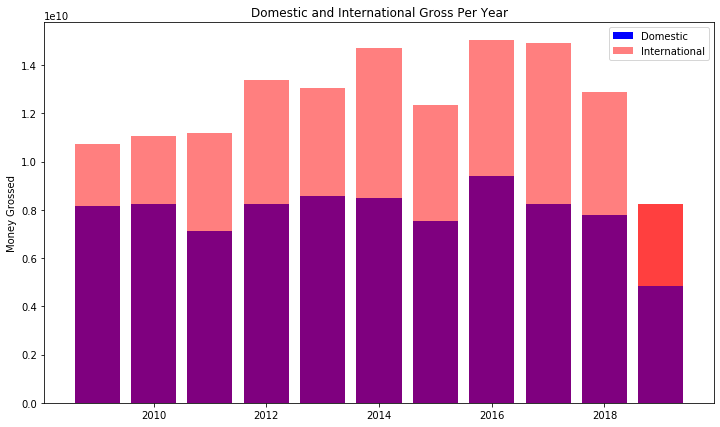

In [301]:
plot_gross_dom_vs_inter(dom_gross,inter_gross)

In [226]:
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2 as chisqr
from scipy import stats as stats
import statsmodels.api as sm
linreg = LinearRegression()

In [219]:
X = final_df['Imdb_Score']
y = final_df['Worldwide Box Office']
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Worldwide Box Office   R-squared (uncentered):                  -8.116
Model:                              OLS   Adj. R-squared (uncentered):             -8.127
Method:                   Least Squares   F-statistic:                             -708.7
Date:                  Wed, 11 Sep 2019   Prob (F-statistic):                        1.00
Time:                          16:08:32   Log-Likelihood:                         -16671.
No. Observations:                   797   AIC:                                  3.334e+04
Df Residuals:                       796   BIC:                                  3.335e+04
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Imdb_Score  4.428e+06   1.58e+05     28.049      0.000    4.12e+06    4.74e+06
==============================================================================
Omnibus:                      564.840   Durbin-Watson:                   0.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8692.973
Skew:                           3.068   Prob(JB):                         0.00
Kurtosis:                      17.971   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [230]:
y = final_df['Imdb_Score'].values.reshape(-1, 1) 
x = final_df['Worldwide Box Office'].values.reshape(-1, 1) 
linreg.fit(x,y)  
y_pred = linreg.predict(x)  
linreg.score(x,y)

0.10050915958474915

Text(0.5, 1.0, 'Imdb Linear Regression')

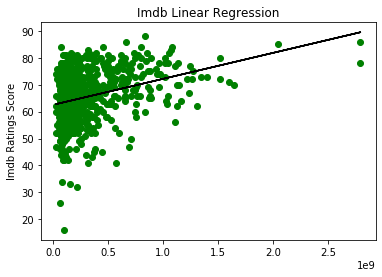

In [231]:
fig,ax = plt.subplots()
ax.scatter(x, y, color='green')
ax.plot(x, y_pred, color='black')
ax.set_xlabel = ('Worldwide Box Office Gross')
ax.set_ylabel('Imdb Ratings Score')
ax.set_title('Imdb Linear Regression')

In [232]:
y = final_df['Rotten_Score'].values.reshape(-1, 1) 
x = final_df['Worldwide Box Office'].values.reshape(-1, 1) 
linreg.fit(x,y)  
y_pred = linreg.predict(x)  
linreg.score(x,y)

0.07057398877046972

Text(0.5, 1.0, 'Rotten Linear Regression')

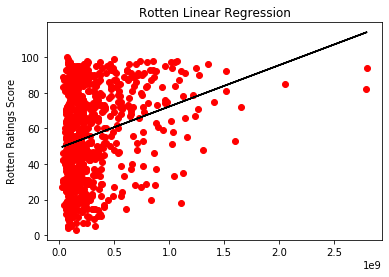

In [233]:
fig,ax = plt.subplots()
ax.scatter(x, y, color='red')
ax.plot(x, y_pred, color='black')
ax.set_xlabel = ('Worldwide Box Office Gross')
ax.set_ylabel('Rotten Ratings Score')
ax.set_title('Rotten Linear Regression')

In [234]:
y = final_df['Metacritic_Score'].values.reshape(-1, 1) 
x = final_df['Worldwide Box Office'].values.reshape(-1, 1) 
linreg.fit(x,y)  
y_pred = linreg.predict(x)  
linreg.score(x,y)

0.06753353240875681

Text(0.5, 1.0, 'Metacritic Linear Regression')

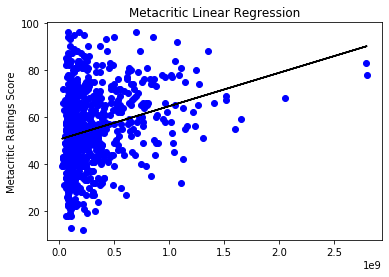

In [235]:
fig,ax = plt.subplots()
ax.scatter(x, y, color='blue')
ax.plot(x, y_pred, color='black')
ax.set_xlabel = ('Worldwide Box Office Gross')
ax.set_ylabel('Metacritic Ratings Score')
ax.set_title('Metacritic Linear Regression')

In [236]:
import seaborn as sns

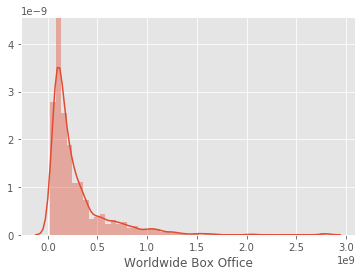

In [203]:
sns.distplot(final_df['Worldwide Box Office'])

In [163]:
Y = final_df['Worldwide Box Office'].values.reshape(-1, 1) 
X = final_df['Imdb_Score'].values.reshape(-1, 1) 

In [165]:
from sklearn.model_selection import train_test_split

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=10)

In [196]:
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [212]:
pred = linreg.predict(X_test)

In [205]:
print(linreg.coef_)

[[10968917.78245148]]


In [206]:
print(linreg.intercept_)

[-4.37769198e+08]


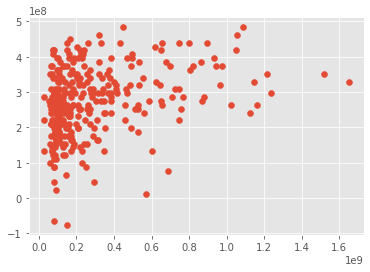

In [198]:
plt.scatter(y_test,pred)


In [201]:
import numpy as np

In [202]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error: 185022622.61864415
Mean Squared Error: 6.763330720060035e+16
Root Mean Squared Error: 260064044.42098555


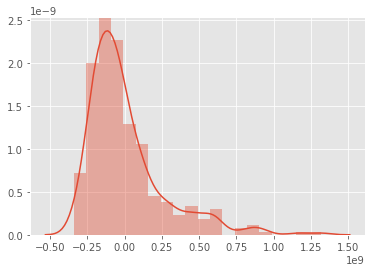

In [213]:
sns.distplot((y_test - pred), bins=20)

In [244]:
X = final_df[['Rotten_Score','Metacritic_Score','Imdb_Score']]
y = final_df['Worldwide Box Office']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=10)
from sklearn.metrics import mean_squared_error, r2_score

In [247]:
reg = LinearRegression()
reg.fit(X_train[['Rotten_Score','Metacritic_Score','Imdb_Score']], y_train)
y_predicted = reg.predict(X_test[['Rotten_Score','Metacritic_Score','Imdb_Score']])
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_predicted))
print('R²: %.2f' % r2_score(y_test, y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))

Mean squared error: 74015874495415536.00
R²: 0.04
Root Mean Squared Error: 272058586.5129339


In [236]:
y = final_df[['Metacritic_Score','Rotten_Score','Imdb_Score']].values.reshape(-1,1)
x = final_df['Worldwide Box Office'].values.reshape(-1,1)
linreg.fit(x,y)  
y_pred = linreg.predict(x)  
linreg.score(x,y)

0.03477060682089628

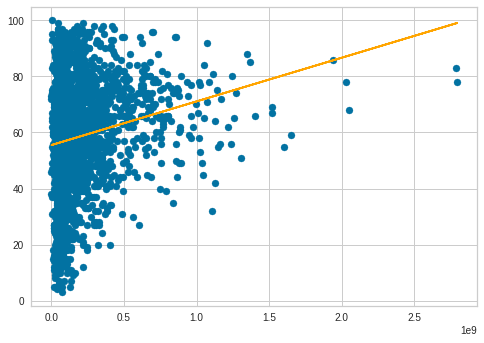

In [237]:
plt.scatter(x, y)
plt.plot(x, y_pred, color='orange')

In [146]:
def bootstrap(df, num_observations, resamples=1000):
    """Draw bootstrap resamples from the data frame from one ratings column.

    Parameters
    ----------
    num_observations: int
        The number of obserations you want to pull.
    
    resamples: int
      The number of bootstrap samples to draw from data frame.
    
    Returns
    -------
    bootstrap_samples: List[np.array]
      The bootsrap resamples from the column in the data frame.  
      Each array is a single bootstrap sample.
    """
    bootstrap_samples = []
    for k in range(resamples):
        boot_indxs = np.random.randint(num_observations, size=num_observations)
        boot_sample = df[boot_indxs]
        bootstrap_samples.append(boot_sample)
    return bootstrap_samples

In [201]:
imdb_sampling = bootstrap(final_df['Imdb_Score'],30,resamples=100)

In [202]:
np.mean(imdb_sampling)

66.57

In [203]:
rotten_sampling = bootstrap(final_df['Rotten_Score'],30,resamples=100)

In [204]:
np.mean(rotten_sampling)

55.19566666666667

In [205]:
meta_sampling = bootstrap(final_df['Metacritic_Score'],30,resamples=100)

In [206]:
np.mean(meta_sampling)

54.98233333333334

In [207]:
def bootstrap_confidence_interval(boostrap_samples, stat_function=np.mean, ci=95):
    """Calculate the CI of chosen sample statistic using bootstrap sampling.

    CI = confidence interval

    Parameters
    ----------
    bootstrap_sample: Numpy array
        Array of samples from bootstrap method

    stat_function: function, optional (default=np.mean)
        Function for calculating as sample statistic on data

    ci: int, optional (default=95)
        Percent of distribution encompassed by CI, 0<ci<100

    Returns
    -------
    tuple: lower_ci(float), upper_ci(float), bootstrap_samples_statistic(array)
        Lower and upper bounds of CI, sample stat from each bootstrap sample
    """
    bootstrap_samples_stat = list(map(stat_function, boostrap_samples))
    low_bound = (100. - ci) / 2
    high_bound = 100. - low_bound
    lower_ci, upper_ci = np.percentile(bootstrap_samples_stat,
                                       [low_bound, high_bound])
    return lower_ci, upper_ci, bootstrap_samples_stat

In [208]:
lower_ci, upper_ci, bootstrap_means_prod = bootstrap_confidence_interval(imdb_sampling, ci=95)
print("The 95% bootstrapped CI of the mean: ({}, {})".format(lower_ci, upper_ci))

The 95% bootstrapped CI of the mean: (63.398333333333326, 70.03333333333333)


Text(0.5, 1.0, 'Imdb Bootstrap Samples')

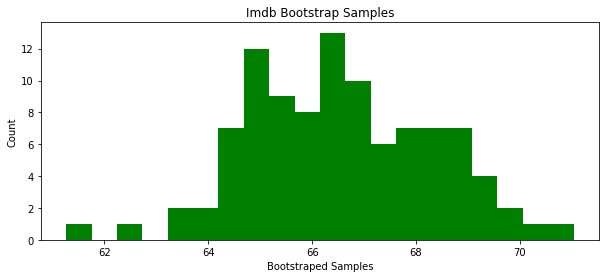

In [209]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.hist(bootstrap_means_prod, bins=20,color='green')
ax.set_ylabel('Count')
ax.set_xlabel('Bootstraped Samples')
ax.set_title('Imdb Bootstrap Samples')

In [210]:
lower_ci, upper_ci, bootstrap_means_prod = bootstrap_confidence_interval(rotten_sampling, ci=95)
print("The 95% bootstrapped CI of the mean: ({}, {})".format(lower_ci, upper_ci))

The 95% bootstrapped CI of the mean: (45.969166666666666, 63.19083333333333)


Text(0.5, 1.0, 'Rotten Tomato Bootstrap Samples')

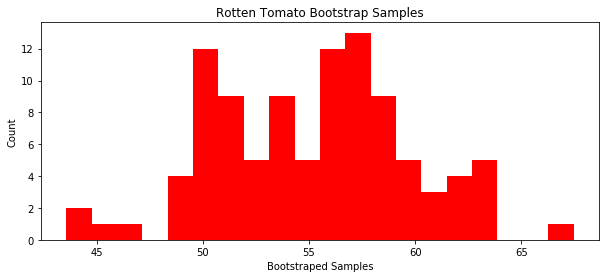

In [211]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.hist(bootstrap_means_prod, bins=20, color='red')
ax.set_ylabel('Count')
ax.set_xlabel('Bootstraped Samples')
ax.set_title('Rotten Tomato Bootstrap Samples')

In [212]:
lower_ci, upper_ci, bootstrap_means_prod = bootstrap_confidence_interval(meta_sampling, ci=95)
print("The 95% bootstrapped CI of the mean: ({}, {})".format(lower_ci, upper_ci))

The 95% bootstrapped CI of the mean: (48.43166666666667, 60.968333333333334)


Text(0.5, 1.0, 'Metacrtitic Bootstrap Samples')

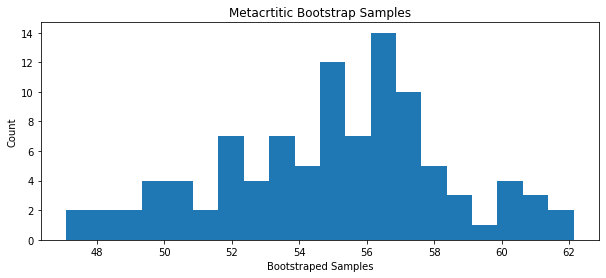

In [213]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.hist(bootstrap_means_prod, bins=20)
ax.set_ylabel('Count')
ax.set_xlabel('Bootstraped Samples')
ax.set_title('Metacrtitic Bootstrap Samples')

In [ ]:
import numpy as np
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [ ]:
mean = final_df['Imdb_Score'].mean()
stdev = final_df['Imdb_Score'].std()
print(mean, stdev)

In [ ]:
population = np.random.normal(loc=mean, scale=stdev, size=50000)
# take 1k 'samples' from the larger population
samples = population[:1000]
print(bs.bootstrap(samples, stat_func=bs_stats.mean))
# >> 100.08  (99.46, 100.69)
print(bs.bootstrap(samples, stat_func=bs_stats.std))
# >> 9.49  (9.92, 10.36)

/home/colin/anaconda3/lib/python3.7/site-packages/yellowbrick/regressor/influence.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  self.distance_, linefmt=self.linefmt, markerfmt=self.markerfmt


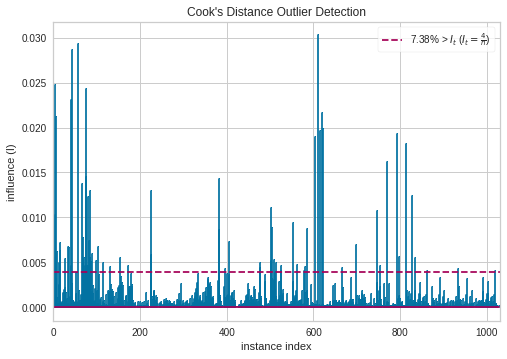

In [218]:
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete
X, y = load_concrete()
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.poof()